# Personalized Stock Recommender Systems

In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix

import torch
import torch.optim as optim
import torch.utils.data as data

from src import mf_bpr, als, word2vec, metrics, datasets, utils

## Prepare Data

### Dummy Data

In [2]:
# Read data
def read_dummy():
    dummy_data = pd.read_csv("data/dummy.data", sep='\t', names = ['user_id', 'item_id',
        'rating', 'timestamp'], engine = "python")
    num_users = dummy_data.user_id.unique().shape[0]
    num_items = dummy_data.item_id.unique().shape[0]
    return dummy_data, num_users, num_items

### Representative UCI Data

In [3]:
def read_uci():
    # Read data
    uci_data = pd.read_excel("data/data_UCI.xlsx", header = 0, engine = "openpyxl")

    # Massage data
    uci_data = uci_data[pd.isnull(uci_data["investor_id"]) == False]
    uci_data = uci_data.drop_duplicates(subset = ["investor_id", "stock_id"])

    v = uci_data["investor_id"].value_counts()
    uci_data = uci_data[uci_data["investor_id"].isin(v.index[v.gt(20)])]

    uci_data["investor_id"], _ = pd.factorize(uci_data["investor_id"])
    uci_data["stock_id"], _ = pd.factorize(uci_data["stock_id"])

    num_investors = uci_data.investor_id.unique().shape[0]
    num_stocks = uci_data.stock_id.unique().shape[0]
    return uci_data, num_investors, num_stocks

## Matrix Factorization with BPR

In [4]:
# Define evaluator
def evaluate_ranking_bpr(net, test_input, interactions, num_users, num_items):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_items)])
    for u in range(num_users):
        neg_items = list(all_items - set(interactions[u]))
        user_ids, item_ids, scores = [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        test_dataset = data.TensorDataset(torch.from_numpy(np.array(user_ids)),    
            torch.from_numpy(np.array(item_ids)))
        test_data_iter = data.DataLoader(test_dataset, shuffle=False, batch_size=1024)

        for _, (user_idxs, item_idxs) in enumerate(test_data_iter):
            scores.extend(list(net(user_idxs, item_idxs).detach().numpy()))
        item_scores = list(zip(item_ids, scores))

        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        
        temp = metrics.hit_and_auc(ranked_items[u], test_input[u][0], 100)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

#### Dummy Data

In [5]:
# Train test split
def train_test_dummy_bpr(dummy_data : pd.DataFrame, num_users : int, num_items : int):
    train_items, test_items, train_list = {}, {}, []

    # Iterate through every line in the raw data
    for line in dummy_data.itertuples():
        u, i, rating, time = line[1], line[2], line[3], line[4]
        train_items.setdefault(u, []).append((u, i, rating, time))
        if u not in test_items or test_items[u][2] < time:
            test_items[u] = (i, rating, time)
        
    # Iterate through every user and add their samples, sorted by timestamp, to the train 
    # list
    for u in range(1, num_users + 1):
        train_list.extend(sorted(train_items[u], key = (lambda x : x[3])))

    test_data = [(key, *value) for key, value in test_items.items()]

    train_data = [item for item in train_list if item not in test_data]
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    return train_data, test_data

In [6]:
# Load user and item indices (zero based) and scores 
def load_dummy_bpr(dummy, num_users, num_items):
    users, items, scores = [], [], []
    interactions = {}
    for line in dummy.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = 1 # implicit

        users.append(user_index)
        items.append(item_index)
        scores.append(score)

        interactions.setdefault(user_index, []).append(item_index)

    return users, items, scores, interactions

In [7]:
# Ready dummy data
dummy_data, num_users, num_items = read_dummy()
train_dummy, test_dummy = train_test_dummy_bpr(dummy_data, num_users, num_items)

# Training data
train_users, train_items, train_ratings, interactions = load_dummy_bpr(train_dummy,    
    num_users, num_items)
train_dummy_dataset = datasets.PairwiseDataset(np.array(train_users), np.array(train_items),
    interactions, num_items)
train_dataloader = data.DataLoader(dataset = train_dummy_dataset, batch_size = 1024, 
    shuffle = True, num_workers = 4)

# Test data
_, _, _, test_interactions = load_dummy_bpr(test_dummy, 
    num_users, num_items)

In [8]:
# Create and initialize model
lr, num_epochs, wd, latent_factors = 0.01, 20, 1e-5, 10

bpr_net = mf_bpr.MF_BPR(num_users, num_items, latent_factors) 
loss = mf_bpr.BPR_Loss
optimizer = optim.Adam(bpr_net.parameters(), lr = 0.01, weight_decay=wd)

In [9]:
# Train and evaluate the model
hit_rate_list_bpr_dummy = []
auc_list_bpr_dummy = []
for epoch in range(num_epochs):
    accumulator, l = utils.Accumulator(2), 0.

    # Train each batch
    bpr_net.train()
    for i, (user_idxs, item_idxs, neg_items) in enumerate(train_dataloader):
        optimizer.zero_grad()

        p_pos = bpr_net(user_idxs, item_idxs)
        p_neg = bpr_net(user_idxs, neg_items)

        total_loss = loss(p_pos, p_neg)
        total_loss.backward()
        optimizer.step()
        accumulator.add(total_loss, user_idxs.shape[0])

    # Evaluate
    bpr_net.eval()
    hit_rate, auc = evaluate_ranking_bpr(bpr_net, test_interactions, interactions, num_users,   
        num_items)
    hit_rate_list_bpr_dummy.append(hit_rate)
    auc_list_bpr_dummy.append(auc)

    print(f"Epoch {epoch}:\n\tloss = {accumulator[0]/accumulator[1]}\n\thit_rate = {hit_rate}\n\tauc = {auc}")

Epoch 0:
	loss = 0.5341864751402602
	hit_rate = 0.3244962884411453
	auc = 0.7935144107911114
Epoch 1:
	loss = 0.30271980276941246
	hit_rate = 0.3828207847295864
	auc = 0.8292579371856568
Epoch 2:
	loss = 0.26066434621794066
	hit_rate = 0.40402969247083775
	auc = 0.8440037713279825
Epoch 3:
	loss = 0.2320791515406297
	hit_rate = 0.43478260869565216
	auc = 0.856624454825258
Epoch 4:
	loss = 0.2117367948578336
	hit_rate = 0.45068928950159065
	auc = 0.8628309945583741
Epoch 5:
	loss = 0.1970745893726572
	hit_rate = 0.471898197242842
	auc = 0.8673568211601684
Epoch 6:
	loss = 0.18913312497791676
	hit_rate = 0.48462354188759277
	auc = 0.8701351199977285
Epoch 7:
	loss = 0.17850016451031667
	hit_rate = 0.4878048780487805
	auc = 0.8723508075919941
Epoch 8:
	loss = 0.17413264025561828
	hit_rate = 0.4899257688229056
	auc = 0.8759666098213753
Epoch 9:
	loss = 0.1653420816373352
	hit_rate = 0.48462354188759277
	auc = 0.8783381033957195
Epoch 10:
	loss = 0.16491006005725792
	hit_rate = 0.5058324496

(0.0, 1.0)

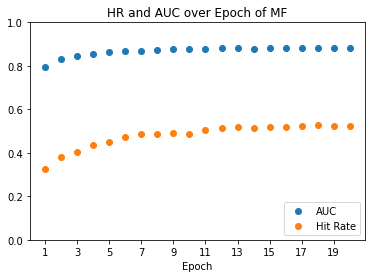

In [63]:
# Visualize
x = list(range(1, num_epochs + 1))
plt.scatter(x, auc_list_bpr_dummy, label = "AUC")
plt.scatter(x, hit_rate_list_bpr_dummy, label = "Hit Rate")
plt.title("HR and AUC over Epoch of MF")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")
plt.xticks(x[0::2])
plt.ylim((0, 1))

### Representative UCI Data

In [11]:
# Train test split
def train_test_uci_bpr(dummy_data : pd.DataFrame, num_users : int, num_items : int):
    train_items, test_items, train_list = {}, {}, []

    # Iterate through every line in the raw data
    for line in dummy_data.itertuples():
        u, i, time = line[1], line[2], line[4]
        train_items.setdefault(u, []).append((u, i, time))
        if u not in test_items or test_items[u][1] < time:
            test_items[u] = (i, time)
        
    # Iterate through every user and add their samples, sorted by timestamp, to the train 
    # list
    for u in range(0, num_users):
        train_list.extend(sorted(train_items[u], key = (lambda x : x[2])))

    test_data = [(key, *value) for key, value in test_items.items()]

    train_data = [item for item in train_list if item not in test_data]
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    return train_data, test_data

In [12]:
# Load user and item indices (zero based) and scores 
def load_uci_bpr(dummy, num_users, num_items):
    users, items, scores = [], [], []
    interactions = {}
    for line in dummy.itertuples():
        user_index, item_index = line[1], line[2]
        score = 1 # implicit

        users.append(user_index)
        items.append(item_index)
        scores.append(score)

        interactions.setdefault(user_index, []).append(item_index)

    return users, items, scores, interactions

In [13]:
# Ready uci data
uci_data, num_users, num_items = read_uci()
train_uci, test_uci = train_test_uci_bpr(uci_data, num_users, num_items)

# Training data
train_users, train_items, train_ratings, interactions = load_uci_bpr(train_uci,    
    num_users, num_items)
train_uci_dataset = datasets.PairwiseDataset(np.array(train_users), np.array(train_items),
    interactions, num_items)
train_dataloader = data.DataLoader(dataset = train_uci_dataset, batch_size = 1024, 
    shuffle = True, num_workers = 4)

# Test data
_, _, _, test_interactions = load_uci_bpr(test_uci, 
    num_users, num_items)

In [14]:
# Create and initialize model
lr, num_epochs, wd, latent_factors = 0.01, 10, 1e-5, 10

bpr_net = mf_bpr.MF_BPR(num_users, num_items, latent_factors) 
loss = mf_bpr.BPR_Loss
optimizer = optim.Adam(bpr_net.parameters(), lr = 0.01, weight_decay=wd)

In [15]:
# Train and evaluate the model
hit_rate_list_bpr_uci = []
auc_list_bpr_uci = []
for epoch in range(num_epochs):
    accumulator, l = utils.Accumulator(2), 0.

    # Train each batch
    bpr_net.train()
    for i, (user_idxs, item_idxs, neg_items) in enumerate(train_dataloader):
        optimizer.zero_grad()

        p_pos = bpr_net(user_idxs, item_idxs)
        p_neg = bpr_net(user_idxs, neg_items)

        total_loss = loss(p_pos, p_neg)
        total_loss.backward()
        optimizer.step()
        accumulator.add(total_loss, user_idxs.shape[0])

    # Evaluate
    bpr_net.eval()
    hit_rate, auc = evaluate_ranking_bpr(bpr_net, test_interactions, interactions, num_users,   
        num_items)
    hit_rate_list_bpr_uci.append(hit_rate)
    auc_list_bpr_uci.append(auc)

    print(f"Epoch {epoch}:\n\tloss = {accumulator[0]/accumulator[1]}\n\thit_rate = {hit_rate}\n\tauc = {auc}")

Epoch 0:
	loss = 0.5383876239948242
	hit_rate = 0.1623989218328841
	auc = 0.7858610574346634
Epoch 1:
	loss = 0.38508427386233535
	hit_rate = 0.18867924528301888
	auc = 0.8019714460435075
Epoch 2:
	loss = 0.3454284756922097
	hit_rate = 0.2011455525606469
	auc = 0.8135754374974532
Epoch 3:
	loss = 0.31781626217579767
	hit_rate = 0.215633423180593
	auc = 0.81945105285775
Epoch 4:
	loss = 0.3025900361309876
	hit_rate = 0.22776280323450135
	auc = 0.8242740771728345
Epoch 5:
	loss = 0.29244100453668503
	hit_rate = 0.22035040431266847
	auc = 0.8255239139930164
Epoch 6:
	loss = 0.28287213873492706
	hit_rate = 0.23349056603773585
	auc = 0.8279725396826766
Epoch 7:
	loss = 0.27570851452975764
	hit_rate = 0.2371967654986523
	auc = 0.8315140851188366
Epoch 8:
	loss = 0.272164781405353
	hit_rate = 0.23888140161725066
	auc = 0.8321457610028096
Epoch 9:
	loss = 0.26954747046004107
	hit_rate = 0.23180592991913745
	auc = 0.8328145953318732


(0.0, 1.0)

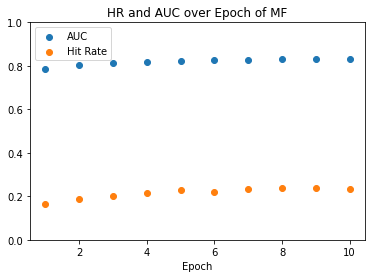

In [64]:
# Visualize
x = list(range(1, num_epochs + 1))
plt.scatter(x, auc_list_bpr_uci, label = "AUC")
plt.scatter(x, hit_rate_list_bpr_uci, label = "Hit Rate")
plt.title("HR and AUC over Epoch of MF")
plt.xlabel("Epoch")
plt.legend()
plt.ylim((0, 1))

## Alternating Least Squares

In [17]:
# Define evaluator
def evaluate_ranking_als(net, test_input, interactions, num_users, num_items):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_items)])
    for u in range(num_users):
        neg_items = list(all_items - set(interactions[u]))
        user_ids, item_ids, scores = [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]

        scores.extend(list(net.predict(user_ids, item_ids)))
        item_scores = list(zip(item_ids, scores))

        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        
        temp = metrics.hit_and_auc(ranked_items[u], test_input[u][0], 100)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

### Dummy Data

In [18]:
# Train test split
def train_test_dummy_als(dummy_data : pd.DataFrame, num_users : int, num_items : int):
    train_items, test_items, train_list = {}, {}, []

    # Iterate through every line in the raw data
    for line in dummy_data.itertuples():
        u, i, rating, time = line[1], line[2], line[3], line[4]
        train_items.setdefault(u, []).append((u, i, rating, time))
        if u not in test_items or test_items[u][2] < time:
            test_items[u] = (i, rating, time)
        
    # Iterate through every user and add their samples, sorted by timestamp, to the train 
    # list
    for u in range(1, num_users + 1):
        train_list.extend(sorted(train_items[u], key = (lambda x : x[3])))

    test_data = [(key, *value) for key, value in test_items.items()]

    train_data = [item for item in train_list if item not in test_data]
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    return train_data, test_data

In [19]:
# Load user and item indices (zero based) and scores 
def load_dummy_als(dummy, num_users, num_items):
    users, items, scores = [], [], []
    interactions = {}
    for line in dummy.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = 1 # implicit

        users.append(user_index)
        items.append(item_index)
        scores.append(score)

        interactions.setdefault(user_index, []).append(item_index)

    return users, items, scores, interactions

In [20]:
# Ready dummy data
dummy_data, num_users, num_items = read_dummy()
train_dummy, test_dummy = train_test_dummy_als(dummy_data, num_users, num_items)

# Training data
train_users, train_items, train_ratings, interactions = load_dummy_als(train_dummy,    
    num_users, num_items)

# Test data
_, _, _, test_interactions = load_dummy_als(test_dummy, 
    num_users, num_items)

In [21]:
# Initialize model
num_epochs, reg, latent_factors = 20, 0.01, 30

ratings_matrix = coo_matrix((train_ratings, (train_users, train_items)), shape = (num_users, 
    num_items)).todense()
als_net = als.ALS(num_users, num_items, latent_factors, ratings_matrix, reg)

In [22]:
# Train and evaluate the model
hit_rate_list_als_dummy = []
auc_list_als_dummy = []
 
for epoch in range(num_epochs):
    # Train with entire batch
    als_net.train()

    # Evaluate
    hit_rate, auc = evaluate_ranking_als(als_net, test_interactions, interactions, num_users,
        num_items)
    hit_rate_list_als_dummy.append(hit_rate)
    auc_list_als_dummy.append(auc)

    print(f"Epoch {epoch}: hit_rate = {hit_rate}, auc = {auc}")

Epoch 0: hit_rate = 0.3828207847295864, auc = 0.77592477683652
Epoch 1: hit_rate = 0.5270413573700954, auc = 0.8513596702214558
Epoch 2: hit_rate = 0.542948038176034, auc = 0.8562110495060666
Epoch 3: hit_rate = 0.5577942735949099, auc = 0.8563503242209484
Epoch 4: hit_rate = 0.5577942735949099, auc = 0.8572101566886059
Epoch 5: hit_rate = 0.5546129374337222, auc = 0.8587740247045237
Epoch 6: hit_rate = 0.5535524920466596, auc = 0.8599331529653808
Epoch 7: hit_rate = 0.5503711558854719, auc = 0.8604072302793093
Epoch 8: hit_rate = 0.5503711558854719, auc = 0.8606158169452216
Epoch 9: hit_rate = 0.5461293743372216, auc = 0.8606990383559968
Epoch 10: hit_rate = 0.5524920466595971, auc = 0.8605475212423879
Epoch 11: hit_rate = 0.5503711558854719, auc = 0.8603969678363855
Epoch 12: hit_rate = 0.5461293743372216, auc = 0.8603013899804807
Epoch 13: hit_rate = 0.545068928950159, auc = 0.8602220496751382
Epoch 14: hit_rate = 0.5461293743372216, auc = 0.8601089413891921
Epoch 15: hit_rate = 0.5

(0.0, 1.0)

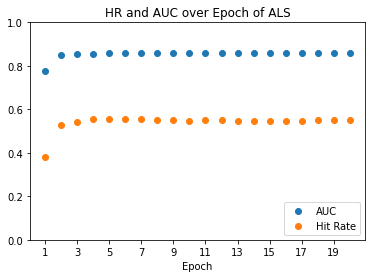

In [65]:
# Visualize
x = list(range(1, num_epochs + 1))
plt.scatter(x, auc_list_als_dummy, label = "AUC")
plt.scatter(x, hit_rate_list_als_dummy, label = "Hit Rate")
plt.title("HR and AUC over Epoch of ALS")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")
plt.xticks(x[0::2])
plt.ylim((0, 1))

### Representative UCI Data

In [24]:
# Train test split
def train_test_uci_als(dummy_data : pd.DataFrame, num_users : int, num_items : int):
    train_items, test_items, train_list = {}, {}, []

    # Iterate through every line in the raw data
    for line in dummy_data.itertuples():
        u, i, time = line[1], line[2], line[4]
        train_items.setdefault(u, []).append((u, i, time))
        if u not in test_items or test_items[u][1] < time:
            test_items[u] = (i, time)
        
    # Iterate through every user and add their samples, sorted by timestamp, to the train 
    # list
    for u in range(0, num_users):
        train_list.extend(sorted(train_items[u], key = (lambda x : x[2])))

    test_data = [(key, *value) for key, value in test_items.items()]

    train_data = [item for item in train_list if item not in test_data]
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    return train_data, test_data

In [25]:
def load_uci_als(dummy, num_users, num_items):
    users, items, scores = [], [], []
    interactions = {}
    for line in dummy.itertuples():
        user_index, item_index = line[1], line[2]
        score = 1 # implicit

        users.append(user_index)
        items.append(item_index)
        scores.append(score)

        interactions.setdefault(user_index, []).append(item_index)

    return users, items, scores, interactions

In [26]:
# Ready uci data
uci_data, num_users, num_items = read_uci()
train_uci, test_uci = train_test_uci_als(uci_data, num_users, num_items)

# Training data
train_users, train_items, train_ratings, interactions = load_uci_als(train_uci,    
    num_users, num_items)

# Test data
_, _, _, test_interactions = load_uci_als(test_uci, 
    num_users, num_items)

In [27]:
# Initialize model
num_epochs, reg, latent_factors = 10, 0.01, 30

ratings_matrix = coo_matrix((train_ratings, (train_users, train_items)), shape = (num_users, 
    num_items)).todense()
als_net = als.ALS(num_users, num_items, latent_factors, ratings_matrix, reg)

In [28]:
# Train and evaluate the model
hit_rate_list_als_uci = []
auc_list_als_uci = []
 
for epoch in range(num_epochs):
    # Train with entire batch
    als_net.train()

    # Evaluate
    hit_rate, auc = evaluate_ranking_als(als_net, test_interactions, interactions, num_users,
        num_items)
    hit_rate_list_als_uci.append(hit_rate)
    auc_list_als_uci.append(auc)

    print(f"Epoch {epoch}: hit_rate = {hit_rate}, auc = {auc}")

Epoch 0: hit_rate = 0.182277628032345, auc = 0.7280741090478785
Epoch 1: hit_rate = 0.30963611859838275, auc = 0.8071175282466837
Epoch 2: hit_rate = 0.32715633423180596, auc = 0.8232923196689633
Epoch 3: hit_rate = 0.33962264150943394, auc = 0.8288654283281104
Epoch 4: hit_rate = 0.33962264150943394, auc = 0.8317992953322314
Epoch 5: hit_rate = 0.3419811320754717, auc = 0.8324763192397514
Epoch 6: hit_rate = 0.33962264150943394, auc = 0.8326289490970995
Epoch 7: hit_rate = 0.3386118598382749, auc = 0.8328948467765028
Epoch 8: hit_rate = 0.3376010781671159, auc = 0.8328663256014958
Epoch 9: hit_rate = 0.3389487870619946, auc = 0.8328413983180396


(0.0, 1.0)

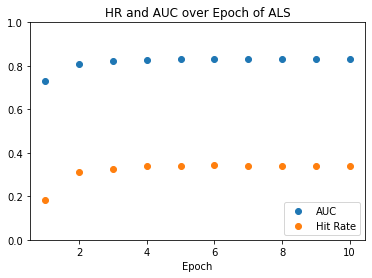

In [66]:
# Visualize
x = list(range(1, num_epochs + 1))
plt.scatter(x, auc_list_als_uci, label = "AUC")
plt.scatter(x, hit_rate_list_als_uci, label = "Hit Rate")
plt.title("HR and AUC over Epoch of ALS")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")
plt.ylim((0, 1))

## Word2Vec

In [30]:
# Define evaluator
def evaluate_ranking_cbow(net, test_targets, test_contexts, num_items):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    item_ids = list(range(num_items))
    
    for _, (targets, contexts) in enumerate(ngrams_dataloader_test):
        scores = net(contexts).tolist()
        for u, row in enumerate(scores):
            item_scores = list(zip(item_ids, row))
            ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
            ranked_items[u] = [r[0] for r in ranked_list[u]]
        
            temp = metrics.hit_and_auc(ranked_items[u], test_targets[u], 100)
            hit_rate.append(temp[0])
            auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

### Dummy Data

In [31]:
# Prep interactions
def load_interactions_cbow(dummy_data : pd.DataFrame):
    interactions = {}
    for line in dummy_data.itertuples():
        user_index, item_index, time = line[1] - 1, line[2] - 1, line[4]
        interactions.setdefault(user_index, []).append((item_index, time))

    interactions = {k : sorted(v, key = (lambda pair : pair[1])) for k, v in interactions.items()}
    return {k : [x[0] for x in v] for k, v in interactions.items()}

In [32]:
# Train test split
def train_test_dummy_cbow(interactions : dict, window : int):
    train_targets, train_contexts = [], []
    test_targets, test_contexts = [], []

    # Iterate through every interaction
    for user_interactions in interactions.values():
        num_interactions = len(user_interactions)
        # Add to training data
        for i in range(window, num_interactions - 1):
            train_targets.append(user_interactions[i])
            train_contexts.append([user_interactions[j] for j in np.arange(i - window, i)])
        # Add to testing data
        test_targets.append(user_interactions[num_interactions - 1])
        test_contexts.append([user_interactions[j] for j 
            in np.arange(num_interactions - 1 - window, num_interactions - 1)])
        
    return train_targets, train_contexts, test_targets, test_contexts

In [33]:
# Prepare data
window = 10

dummy_data, num_users, num_items = read_dummy()
sorted_interactions = load_interactions_cbow(dummy_data)
train_targets, train_contexts, test_targets, test_contexts = train_test_dummy_cbow(sorted_interactions, window)

In [34]:
# Prepare dataset and model
ngrams_train = data.TensorDataset(torch.from_numpy(np.array(train_targets)), 
        torch.from_numpy(np.array(train_contexts)))
ngrams_dataloader = data.DataLoader(dataset = ngrams_train, batch_size = 1024, 
    shuffle = True, num_workers = 4)
ngrams_test = data.TensorDataset(torch.from_numpy(np.array(test_targets)), 
    torch.from_numpy(np.array(test_contexts)))
ngrams_dataloader_test = data.DataLoader(dataset = ngrams_test, batch_size = 1024, 
    shuffle = False, num_workers = 4)

embedding_dim, num_epochs, learning_rate = 30, 20, 0.025
loss = torch.nn.NLLLoss()
cbow_net = word2vec.CBOW(num_items, embedding_dim, window)
optimizer = optim.Adam(cbow_net.parameters(), lr = learning_rate)

In [35]:
# Train and evaluate the model
hit_rate_list_cbow_dummy = []
auc_list_cbow_dummy = []
for epoch in range(num_epochs):
    accumulator, l = utils.Accumulator(2), 0.

    # Train each batch
    cbow_net.train()
    for _, (targets, contexts) in enumerate(ngrams_dataloader):
        optimizer.zero_grad()

        log_probabilities = cbow_net(contexts)

        total_loss = loss(log_probabilities, targets)
        total_loss.backward()
        optimizer.step()
        accumulator.add(total_loss, targets.shape[0])

    # Evaluate
    cbow_net.eval()
    hit_rate, auc = evaluate_ranking_cbow(cbow_net, test_targets, test_contexts, num_items)
    hit_rate_list_cbow_dummy.append(hit_rate)
    auc_list_cbow_dummy.append(auc)

    print(f"Epoch {epoch}:\n\tloss = {accumulator[0]/accumulator[1]}\n\thit_rate = {hit_rate}\n\tauc = {auc}")

Epoch 0:
	loss = 0.006566407481614299
	hit_rate = 0.4093319194061506
	auc = 0.8350423894275929
Epoch 1:
	loss = 0.006052939315925797
	hit_rate = 0.45068928950159065
	auc = 0.8551813891519148
Epoch 2:
	loss = 0.005897940441460468
	hit_rate = 0.4750795334040297
	auc = 0.8599884051242033
Epoch 3:
	loss = 0.005801957607008595
	hit_rate = 0.46553552492046657
	auc = 0.8530800544795143
Epoch 4:
	loss = 0.0057278727424251545
	hit_rate = 0.4750795334040297
	auc = 0.854922113093567
Epoch 5:
	loss = 0.005661655624449065
	hit_rate = 0.46447507953340406
	auc = 0.8582655756464711
Epoch 6:
	loss = 0.005609605656753154
	hit_rate = 0.46447507953340406
	auc = 0.8593354836634004
Epoch 7:
	loss = 0.0055684559512327505
	hit_rate = 0.4485683987274655
	auc = 0.8518625294366644
Epoch 8:
	loss = 0.005534650065716491
	hit_rate = 0.4559915164369035
	auc = 0.8530150777544296
Epoch 9:
	loss = 0.005504175799666032
	hit_rate = 0.4623541887592789
	auc = 0.8510512666360919
Epoch 10:
	loss = 0.005485127403590154
	hit_r

(0.0, 1.0)

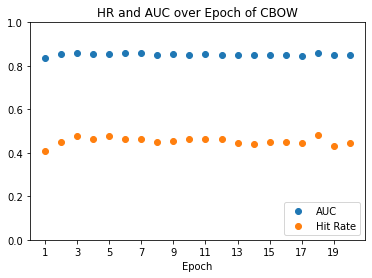

In [67]:
# Visualize
x = list(range(1, num_epochs + 1))
plt.scatter(x, auc_list_cbow_dummy, label = "AUC")
plt.scatter(x, hit_rate_list_cbow_dummy, label = "Hit Rate")
plt.title("HR and AUC over Epoch of CBOW")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")
plt.xticks(x[0::2])
plt.ylim((0, 1))

### Representative UCI Data

In [37]:
# Prep interactions
def load_interactions_cbow(uci_data : pd.DataFrame):
    interactions = {}
    for line in uci_data.itertuples():
        user_index, item_index, time = line[1], line[2], line[4]
        interactions.setdefault(user_index, []).append((item_index, time))

    interactions = {k : sorted(v, key = (lambda pair : pair[1])) for k, v in interactions.items()}
    return {k : [x[0] for x in v] for k, v in interactions.items()}

In [38]:
# Train test split
def train_test_uci_cbow(interactions : dict, window : int):
    train_targets, train_contexts = [], []
    test_targets, test_contexts = [], []

    # Iterate through every interaction
    for user_interactions in interactions.values():
        num_interactions = len(user_interactions)
        # Add to training data
        for i in range(window, num_interactions - 1):
            train_targets.append(user_interactions[i])
            train_contexts.append([user_interactions[j] for j in np.arange(i - window, i)])
        # Add to testing data
        test_targets.append(user_interactions[num_interactions - 1])
        test_contexts.append([user_interactions[j] for j 
            in np.arange(num_interactions - 1 - window, num_interactions - 1)])
        
    return train_targets, train_contexts, test_targets, test_contexts

In [39]:
# Prepare data
window = 10

uci_data, num_users, num_items = read_uci()
sorted_interactions = load_interactions_cbow(uci_data)
train_targets, train_contexts, test_targets, test_contexts = train_test_uci_cbow(sorted_interactions, window)

In [40]:
# Prepare dataset and model
ngrams_train = data.TensorDataset(torch.from_numpy(np.array(train_targets)), 
        torch.from_numpy(np.array(train_contexts)))
ngrams_dataloader = data.DataLoader(dataset = ngrams_train, batch_size = 1024, 
    shuffle = True, num_workers = 4)
ngrams_test = data.TensorDataset(torch.from_numpy(np.array(test_targets)), 
    torch.from_numpy(np.array(test_contexts)))
ngrams_dataloader_test = data.DataLoader(dataset = ngrams_test, batch_size = 1024, 
    shuffle = False, num_workers = 4)

embedding_dim, num_epochs, learning_rate = 30, 10, 0.025
loss = torch.nn.NLLLoss()
cbow_net = word2vec.CBOW(num_items, embedding_dim, window)
optimizer = optim.Adam(cbow_net.parameters(), lr = learning_rate)

In [41]:
# Train and evaluate the model
hit_rate_list_cbow_uci = []
auc_list_cbow_uci = []
for epoch in range(num_epochs):
    accumulator, l = utils.Accumulator(2), 0.

    # Train each batch
    cbow_net.train()
    for _, (targets, contexts) in enumerate(ngrams_dataloader):
        optimizer.zero_grad()

        log_probabilities = cbow_net(contexts)

        total_loss = loss(log_probabilities, targets)
        total_loss.backward()
        optimizer.step()
        accumulator.add(total_loss, targets.shape[0])

    # Evaluate
    cbow_net.eval()
    hit_rate, auc = evaluate_ranking_cbow(cbow_net, test_targets, test_contexts, num_items)
    hit_rate_list_cbow_uci.append(hit_rate)
    auc_list_cbow_uci.append(auc)

    print(f"Epoch {epoch}:\n\tloss = {accumulator[0]/accumulator[1]}\n\thit_rate = {hit_rate}\n\tauc = {auc}")

Epoch 0:
	loss = 0.007554369939913388
	hit_rate = 0.1465633423180593
	auc = 0.7697463616271324
Epoch 1:
	loss = 0.007296600786485475
	hit_rate = 0.14858490566037735
	auc = 0.7637006961324505
Epoch 2:
	loss = 0.007213419585001518
	hit_rate = 0.15498652291105122
	auc = 0.7631056969926902
Epoch 3:
	loss = 0.007141047344738936
	hit_rate = 0.1465633423180593
	auc = 0.7562217573006413
Epoch 4:
	loss = 0.007086766470068487
	hit_rate = 0.15195417789757412
	auc = 0.7637971054771536
Epoch 5:
	loss = 0.007045644641265977
	hit_rate = 0.14690026954177898
	auc = 0.7547534677954189
Epoch 6:
	loss = 0.007019884615579826
	hit_rate = 0.1553234501347709
	auc = 0.7679405015565192
Epoch 7:
	loss = 0.006999123409873466
	hit_rate = 0.14117250673854448
	auc = 0.7537272459241549
Epoch 8:
	loss = 0.0069760255845911345
	hit_rate = 0.14521563342318058
	auc = 0.7532868325973504
Epoch 9:
	loss = 0.0069577368349741375
	hit_rate = 0.14184636118598382
	auc = 0.7518602683947928


(0.0, 1.0)

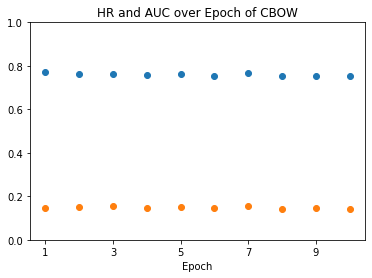

In [68]:
# Visualize
x = list(range(1, num_epochs + 1))
plt.scatter(x, auc_list_cbow_uci, label = "AUC")
plt.scatter(x, hit_rate_list_cbow_uci, label = "Hit Rate")
plt.title("HR and AUC over Epoch of CBOW")
plt.xlabel("Epoch")
plt.xticks(x[0::2])
plt.ylim((0, 1))

## Using a Naive Popularity Based System

In [43]:
# Ready uci data
train_test_uci_pop = train_test_uci_bpr
load_uci_bpr = load_uci_bpr

uci_data, num_users, num_items = read_uci()
train_uci, test_uci = train_test_uci_bpr(uci_data, num_users, num_items)

# Training data
_, train_items, _, _ = load_uci_bpr(train_uci,    
    num_users, num_items)

# Test data
_, test_items, _, _ = load_uci_bpr(test_uci, 
    num_users, num_items)

In [48]:
# Compute hitting rate and AUC
import collections

hit_rate_pop = []
auc_list_pop = []
ranked_list = list(collections.Counter(train_items).keys())
for u in range(num_users):
    temp = metrics.hit_and_auc(ranked_list, test_items[u], 100)
    hit_rate_pop.append(temp[0])
    auc_list_pop.append(temp[1])
hit_rate_pop_avg = sum(hit_rate_pop)/len(hit_rate_pop)
auc_pop_avg = sum(auc_list_pop)/len(auc_list_pop)

## Visualize the Results

(0.5, 1.0)

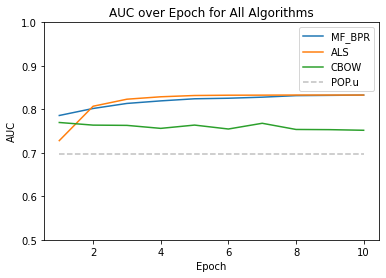

In [69]:
# AUC Plot
x = list(range(1, num_epochs + 1))

plt.plot(x, auc_list_bpr_uci, label = "MF_BPR")
plt.plot(x, auc_list_als_uci, label = "ALS")
plt.plot(x, auc_list_cbow_uci, label = "CBOW")
plt.plot([1, 10], [auc_pop_avg, auc_pop_avg], label = "POP.u", color = "grey", alpha = 0.5, linestyle = "dashed")

plt.title("AUC over Epoch for All Algorithms")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.ylim((0.5, 1))

(0.0, 1.0)

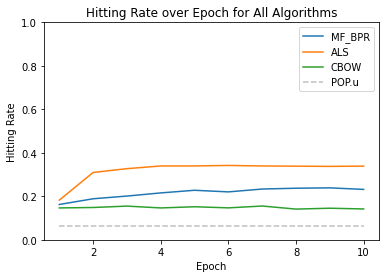

In [70]:
# Hitting Rate Plot
x = list(range(1, num_epochs + 1))

plt.plot(x, hit_rate_list_bpr_uci, label = "MF_BPR")
plt.plot(x, hit_rate_list_als_uci, label = "ALS")
plt.plot(x, hit_rate_list_cbow_uci, label = "CBOW")
plt.plot([1, 10], [hit_rate_pop_avg, hit_rate_pop_avg], label = "POP.u", color = "grey", alpha = 0.5, linestyle = "dashed")

plt.title("Hitting Rate over Epoch for All Algorithms")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Hitting Rate")
plt.ylim((0, 1))